In [47]:
import matplotlib.pyplot as plt

In [48]:
def parse_bmp(file_path):
    with open(file_path, 'rb') as f:
        # 读取BMP文件的头部信息
        header = f.read(54)  # BMP文件头部固定为54字节

        # 提取宽度和高度
        width = int.from_bytes(header[18:22], byteorder='little')
        height = int.from_bytes(header[22:26], byteorder='little')
        bits_per_pixel = int.from_bytes(header[28:30], byteorder='little')
        
        # 计算每行像素的实际字节大小，包括填充
        bytes_per_pixel = bits_per_pixel // 8
        bytes_per_row_without_padding = width * bytes_per_pixel
        padding = (4 - bytes_per_row_without_padding % 4) % 4
        bytes_per_row_with_padding = bytes_per_row_without_padding + padding

        # 跳过文件头，移动到像素数据的起始位置
        f.seek(54)

        # 逐行读取像素数据，考虑行填充
        pixel_data = bytearray()
        for _ in range(height):
            row_data = f.read(bytes_per_row_without_padding)
            pixel_data.extend(row_data)
            f.seek(padding, 1)  # 跳过行填充
        
        return header, pixel_data, width, height, padding, bytes_per_pixel



In [49]:
def calculate_histogram(pixel_data, width, height, bytes_per_pixel, padding):
    histogram = [0] * 256
    for y in range(height):
        for x in range(width):
            index = (y * width + x) * bytes_per_pixel + y * padding
            # 这里假设图像是灰度的，所以我们只取第一个颜色通道
            color = pixel_data[index]
            histogram[color] += 1

    return histogram


In [50]:
def equalize_histogram(pixel_data, histogram, width, height, bytes_per_pixel, padding):
    # 计算累积直方图（CDF）
    cdf = [0] * len(histogram)
    cdf_min = None
    sum_h = 0
    for i, h in enumerate(histogram):
        sum_h += h
        if cdf_min is None and h > 0:
            cdf_min = sum_h
        cdf[i] = sum_h
    total_pixels = width * height

    # 计算直方图均衡化的映射
    equalize_map = [0] * 256
    for i in range(256):
        if cdf[i] > 0:
            equalize_map[i] = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * 255)

    # 应用直方图均衡化映射
    for y in range(height):
        for x in range(width):
            index = (y * width + x) * bytes_per_pixel + y * padding
            pixel_value = pixel_data[index]
            equalized_value = equalize_map[pixel_value]
            # 更新像素值
            for b in range(bytes_per_pixel):
                pixel_data[index + b] = equalized_value

    return pixel_data



In [51]:
def plot_histogram(histogram, title):
    plt.bar(range(256), histogram, color='gray')
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Pixel Count')
    plt.xlim([0, 255])
    plt.show()


In [52]:
def save_bmp(output_path, header, pixel_data):
    with open(output_path, 'wb') as f:
        f.write(header)
        f.write(pixel_data)


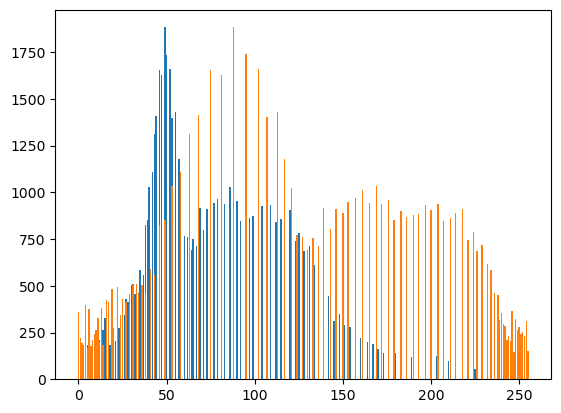

In [53]:
 # 解析BMP文件
header, pixel_data, width, height, padding, bytes_per_pixel = parse_bmp('/Users/sksx085/Desktop/各种实验报告等狗屎/数字图像处理/converted_image.bmp')

# 计算处理前的直方图
original_histogram = calculate_histogram(pixel_data, width, height, bytes_per_pixel, padding)

# 应用直方图均衡化
equalized_pixel_data = equalize_histogram(pixel_data, original_histogram, width, height, bytes_per_pixel, padding)

# 计算处理后的直方图
equalized_histogram = calculate_histogram(equalized_pixel_data, width, height, bytes_per_pixel, padding)

# 保存处理后的图像
save_bmp('/Users/sksx085/Desktop/各种实验报告等狗屎/数字图像处理/exp2/converted_image_equalized.bmp', header, equalized_pixel_data)

#保存处理前的直方图
plt.bar(range(256), original_histogram)
plt.savefig('/Users/sksx085/Desktop/各种实验报告等狗屎/数字图像处理/exp2/original_histogram.png') 

#保存处理后的直方图
plt.bar(range(256), equalized_histogram)
plt.savefig('/Users/sksx085/Desktop/各种实验报告等狗屎/数字图像处理/exp2/equalized_histogram.png') 